In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

For us to be able to start we first must define coordinate functions for a hypotrochoid curve together with provided parameters $a=1$ and $-11/7$. Those are
- $x(t)=(a+b)\cos(t) + b\cos(\frac{a+b}{b}t)$
- $y(t)=(a+b)\sin(t) + b\sin(\frac{a+b}{b}t)$

Or more compact
- $p(t)=(x(t),y(t))$

In [2]:
a = 1
b = -11/7

# Base functions for x and y coordinates of a hypotrochoid
x = lambda t: (a+b) * np.cos(t) + b * np.cos((a+b)/b * t)
y = lambda t: (a+b) * np.sin(t) + b * np.sin((a+b)/b * t)

Now it's a good idea that we check out how the shape traced by this curve looks. For the convince and further explanation I've provided the slider.

0

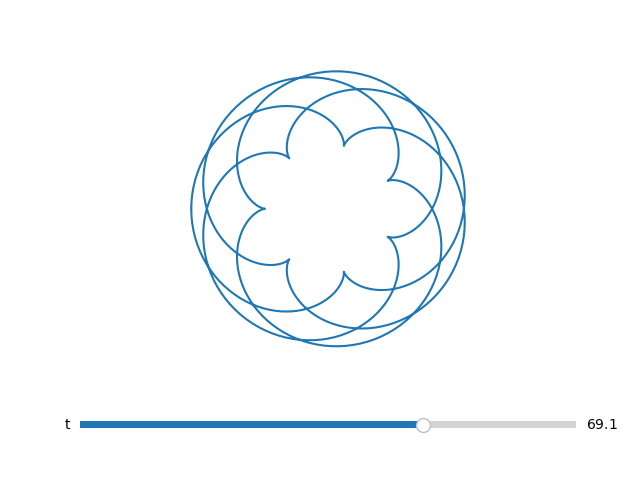

In [25]:
%matplotlib widget
fig, ax = plt.subplots()
ax.set_xlim((-2.2,2.2))
ax.set_ylim((-2.2,2.2))
ax.axis('equal')
ax.axis('off')
fig.subplots_adjust(bottom=0.25)
slider_ax = fig.add_axes([0.125, 0.1, 0.9 - 0.125, 0.03])
slider_el = Slider(ax=slider_ax, valmin=0., valmax=100, valinit=22*np.pi, label='t')

t = np.arange(0,22*np.pi,0.1)
line, = ax.plot(x(t),y(t))

def update(val):
  t = np.arange(0,val,0.1)
  line.set_xdata(x(t))
  line.set_ydata(y(t))
  fig.canvas.draw_idle()

slider_el.on_changed(update)

As we can see the curve returns to it's original position when $t\approx70$ or more precisely $t=22\pi$ and then it traces the same shape again. We can also notice that to compute the area of the shape this curve traces we can focus only on the upper part since the curve is symmetric about the $x$-axis. The other observation it that there are points that share $x$ coordinate but have different $y$ coordinates and vice versa, which complicates our computation.

To go around this issue I've decided to focus only on the upmost part of the curve, in other words we must find subintervals $t_i$ of $t$ such that for all $s_1\in t_i$ there doesn't  exist $s_2\in t$ such that $s_1=s_2$, $x(s_1)=x(s_2)$ and $y(s_1)<y(s_2)$. We can see that there are four such intervals. One way we can find them is to find points where the curve interests itself. Again there are four such points. If we play around with the slider we can see that parameters $t$ for this points are approximately:
- $p(-1)\approx p(-18)$
- $p(-20)\approx p(-40)$
- $p(-40)\approx p(-60)$
- $p(-10)\approx p(-60)$

Note that we are using interval $[-22\pi,0]$ since this way the curve traces the upper part first. Those are only initial approximations and we must refine them. In order to do that I decided on two methods: finding zero of difference of coordinate functions and minimizing the error.

The first method works by finding the solutions of a equation $p(t_1)-p(t_2)=0$. As the equation is not linear I've decided to Newton's method. 

The second method works by minimizing $\vert \vert p(t_1)-p(t_2)\vert \vert$, here I've decided to use gradient descent. 

In both methods we input our initial approximations $t_{1,2}$ and we *hopefully* get better approximations as an output. We stop the iteration after relative error of two consecutive iterations is smaller than $10^{-10}$.

Since we need bunch of different derivatives for each of the methods we first define those.

In [4]:
# Derivatives of coordinate functions
dx = lambda t: - (a+b) * (np.sin(t) + np.sin((a+b)/b * t))
dy = lambda t: (a+b) * (np.cos(t) + np.cos((a+b)/b * t))

# Function and gradient for finding intersection with Newtons method
fi = lambda t : np.array([x(t[0]) - x(t[1]),y(t[0]) - y(t[1])]).T
grad_fi = lambda t : np.array([[dx(t[0]),-dx(t[1])], [dy(t[0]),-dy(t[1])]])

# Function and gradient for finding intersection with gradient descent method
gi = lambda t : np.square(x(t[0]) - x(t[1])) + np.square(y(t[0]) - y(t[1]))
grad_gi = lambda t : np.array([(x(t[0]) - x(t[1])) * dx(t[0]) + (y(t[0]) - y(t[1])) * dy(t[0]), - (x(t[0]) - x(t[1])) * dx(t[1]) - (y(t[0]) - y(t[1])) * dy(t[1])])

Now it's time to improve our approximations

In [5]:
# Newton method
def findIntersectionZero(t, eps = 1e-10):
  dt = np.inf
  while np.linalg.norm(fi(t)) > eps:
    dt = np.linalg.solve(grad_fi(t),-fi(t))
    t = t + dt  
  return t

# Gradient descent
def findIntersectionGrad(t, eps = 1e-10):
  while np.sqrt(gi(t)) > eps:
    t = t - 0.1 * grad_gi(t)
  return t

intersections_initial = [[-1,-18], [-20,-40], [-40,-60], [-10,-60]]
intersections__zero = np.array([findIntersectionZero(p) for p in intersections_initial])
intersections__grad = np.array([findIntersectionGrad(p) for p in intersections_initial])

print("Intersections with Newtons method", intersections__zero,"","Intersections with gradient descent method", intersections__zero,  sep="\n")
print("\nDifference between them: ", np.linalg.norm(intersections__zero - intersections__grad))

Intersections with Newtons method
[[ -0.84603678 -18.90111705]
 [-20.5931906  -38.64827087]
 [-40.34034442 -58.39542469]
 [ -9.02754014 -60.08749824]]

Intersections with gradient descent method
[[ -0.84603678 -18.90111705]
 [-20.5931906  -38.64827087]
 [-40.34034442 -58.39542469]
 [ -9.02754014 -60.08749824]]

Difference between them:  9.961622910553742e-10


As we can see both methods achieve similar results where the difference between them is approximately $10^{-10}$. Now it's time to construct the intervals and just to be sure draw them.

[[ -0.84603678   0.        ]
 [-20.5931906  -18.90111705]
 [-40.34034442 -38.64827087]
 [-60.08749824 -58.39542469]]


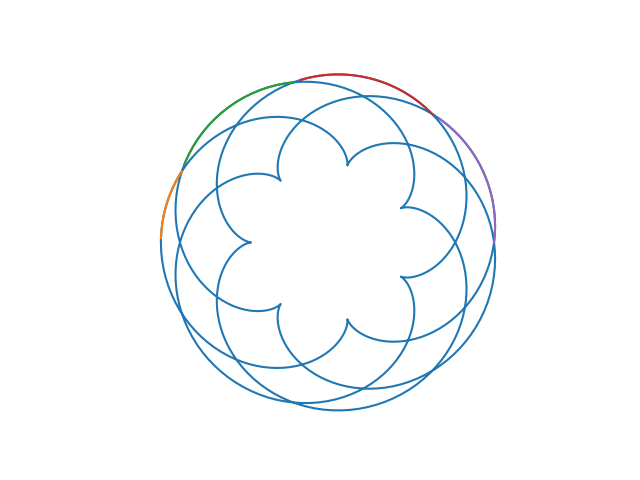

In [26]:
# Construct separate intervals where we do integrations
intersections = intersections__zero
interval_1 = [intersections[0][0], 0]
interval_2 = [intersections[1][0], intersections[0][1]]
interval_3 = [intersections[2][0], intersections[1][1]]
interval_4 = [intersections[3][1], intersections[2][1]]
intervals = np.array([interval_1, interval_2,interval_3,interval_4])

print(intervals, sep="\n")

fix, ax = plt.subplots()
ax.axis('equal')
ax.axis('off')

t = np.arange(0,22*np.pi,0.1)
ax.plot(x(t),y(t))
for interval in intervals:
  t = np.arange(*interval,0.1)
  ax.plot(x(t),y(t))

So far it looks we've done an ok job. Intervals don't intersect completely but it's good enough. Now the last step is integrating the curve over the intervals with the usual formula for parametric curves:
- $\int_{a}^{b}x'(t)y(t)dt$

For this I reused integration method implementation we used in the previous part of the homework. Lastly we sum up the results, multiply by two and call it a day. 

In [28]:
from normal import *

# Area function for integration
area = lambda t : dx(t) * y(t)

res = 0
for interval in intervals:
  res += adaptiveTrapezoidal(area, interval[1], interval[0],1e-10)
res*=2
print(f"The result is {res}")

The result is 14.158197590520743
